In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from models import cnn
from utils import data, train

import numpy as np
import os

from matplotlib import pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [ ]:
batch_size=64

In [ ]:
# Define data transformation
transform = transforms.Compose(
    [
        transforms.ToTensor(), # Transform image to torch.tensor
         transforms.Normalize((1,), (1,)) # Normalize
    ]
)

In [ ]:
# Download train and test sets
train_set = datasets.CIFAR10(
    root="data/CIFAR10", train=True, download=True, transform=transform
)
test_set = datasets.CIFAR10(
    root="data/CIFAR10", train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = ["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [ ]:
train_loader, validation_loader = data.split_train_and_validation(train_set, batch_size)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [ ]:
# Load a batch of train images (and labels)
train_iterator = iter(train_loader)
images, labels = train_iterator.next()
images = images.numpy()

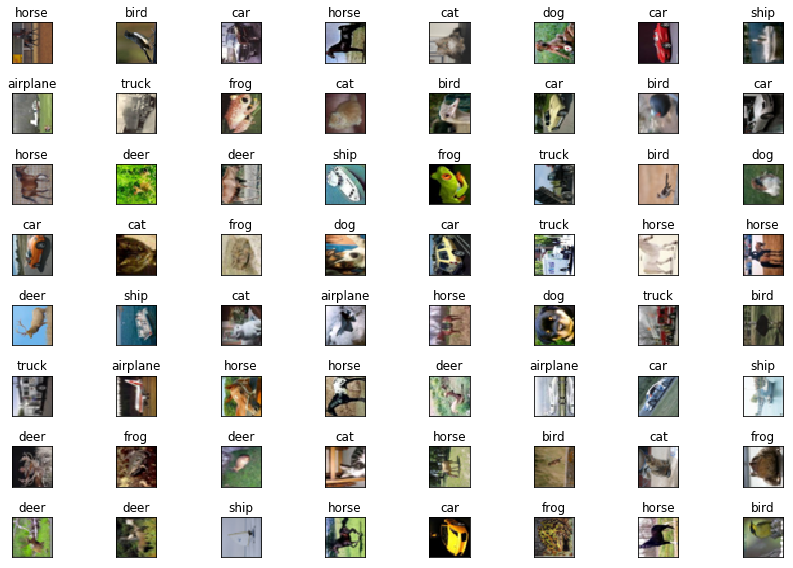

In [ ]:
# Plot batch of train images
fig = plt.figure(figsize=(12,8))
for idx in range(batch_size):
    n = np.rint(np.sqrt(batch_size))
    ax = fig.add_subplot(n, n, idx + 1, xticks=[], yticks=[])
    img = (images[idx].T + 1) * 1
    plt.imshow(img)  # Un-normalise
    ax.set_title(classes[labels[idx].item()], fontdict={"fontsize": 12})
plt.tight_layout()
plt.show()

In [ ]:
# Maxpooling halves the height and widt of the image for every convolution
# With 3 convolutions: 32 x 32 -> 16 x 16 -> 8 x 8
cnn_img_size= 8 * 8

# Define the model
model = cnn.CNN((3, 8, 16), (cnn_img_size * 16, 32, 16, 10))

print(model)

# Move model to device
model = model.to(device)

CNN(
  (cnn): ModuleList(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): ModuleList(
    (0): Linear(in_features=1024, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [ ]:
# Set optimizer and bind to model
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# Define loss
loss = nn.NLLLoss()

Epoch: 0
    Training Loss: 0.453603    Validation Loss: 0.453603
        Validation loss decreased. Saving model...
Epoch: 1
    Training Loss: 0.419466    Validation Loss: 0.419466
        Validation loss decreased. Saving model...
Epoch: 2
    Training Loss: 0.400383    Validation Loss: 0.400383
        Validation loss decreased. Saving model...
Epoch: 3
    Training Loss: 0.367031    Validation Loss: 0.367031
        Validation loss decreased. Saving model...
Epoch: 4
    Training Loss: 0.337061    Validation Loss: 0.337061
        Validation loss decreased. Saving model...
Epoch: 5
    Training Loss: 0.330970    Validation Loss: 0.330970
        Validation loss decreased. Saving model...
Epoch: 6
    Training Loss: 0.315199    Validation Loss: 0.315199
        Validation loss decreased. Saving model...
Epoch: 7
    Training Loss: 0.301180    Validation Loss: 0.301180
        Validation loss decreased. Saving model...
Epoch: 8
    Training Loss: 0.320808    Validation Loss: 0.32080

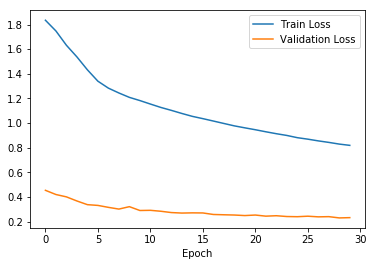

In [ ]:
# Train model
epochs = 30
model_name = "data/CIFAR10/cnn_CFAR10.pt"
if os.path.isfile(model_name):
    # Load the model
    model.load_state_dict(torch.load(model_name))
else:
    train_loss, validation_loss = train.train(
        epochs,
        model,
        loss,
        optimizer,
        train_loader,
        validation_loader,
        model_name,
        device,
    )

    # Show train and validation losses
    fig = plt.figure()
    plt.plot(range(epochs), train_loss, label="Train Loss")
    plt.plot(range(epochs), validation_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [ ]:
# Test the model
test_loss = 0.0
class_correct = list(range(10))
class_total = list(range(10))
model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    predicted = model(data)
    l = loss(predicted, target)
    test_loss += l.item() * data.size(0)
    _, pred = torch.max(predicted, dim=1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss / len(test_loader)
print(f"Test Loss: {test_loss:.6f}")
for i in range(10):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        num_correct = np.sum(class_correct[i])
        num_total = np.sum(class_total[i])
        print(f"Test Accuracy of {classes[i]}: {accuracy:.2f}% ({num_correct}/{num_total})")
    else:
        print(f"Test Accuracy of {classes[i]}: N/A")

Test Loss: 73.039406
Test Accuracy of airplane: 70.20% (702/1000)
Test Accuracy of car: 70.83% (709/1001)
Test Accuracy of bird: 45.01% (451/1002)
Test Accuracy of cat: 44.07% (442/1003)
Test Accuracy of deer: 49.40% (496/1004)
Test Accuracy of dog: 41.49% (417/1005)
Test Accuracy of frog: 81.41% (819/1006)
Test Accuracy of horse: 65.04% (655/1007)
Test Accuracy of ship: 68.55% (691/1008)
Test Accuracy of truck: 65.11% (657/1009)


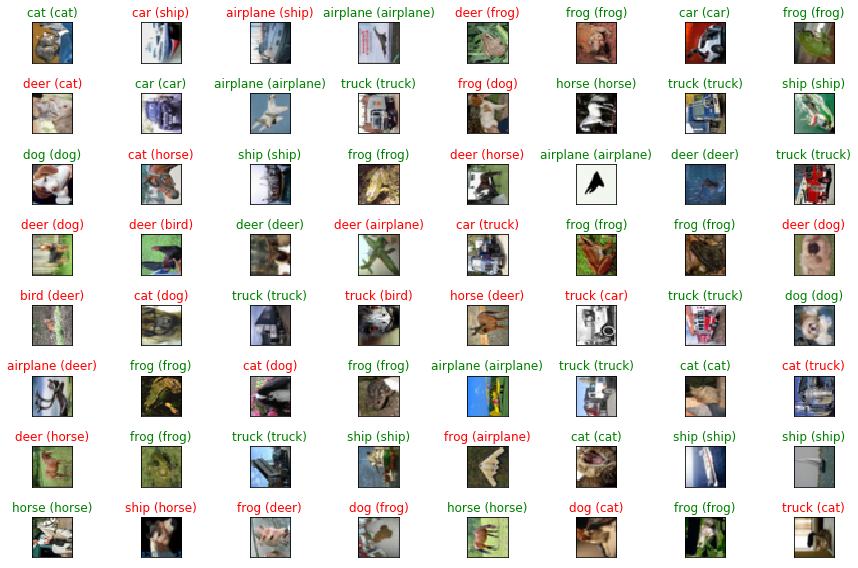

In [ ]:
# Load a batch of test images (and labels) and compute predictions
model = model.to("cpu")
test_iterator = iter(test_loader)
images, labels = test_iterator.next()
predicted = model(images)
_, preds = torch.max(predicted, dim=1)
images = images.numpy()

# Plot batch of test images
fig = plt.figure(figsize=(12,8))
for idx in range(batch_size):
    n = np.rint(np.sqrt(batch_size))
    ax = fig.add_subplot(n, n, idx + 1, xticks=[], yticks=[])
    plt.imshow((images[idx].T + 1) * 1)  # Un-normalise
    ax.set_title(
        f"{classes[preds[idx].item()]} ({classes[labels[idx].item()]})",
        fontdict={"fontsize": 12},
        color=("green" if preds[idx] == labels[idx] else "red"),
    )
plt.tight_layout()
plt.show()